   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Embarked  HasCabin Title  FamilySize  \
0      0         A/5 21171   7.2500        S         0    Mr           2   
1      0          PC 17599  71.2833        C         1   Mrs           2   
2      0  STON/O2. 3101282   7.9250        S         0  Miss           1   
3      0        

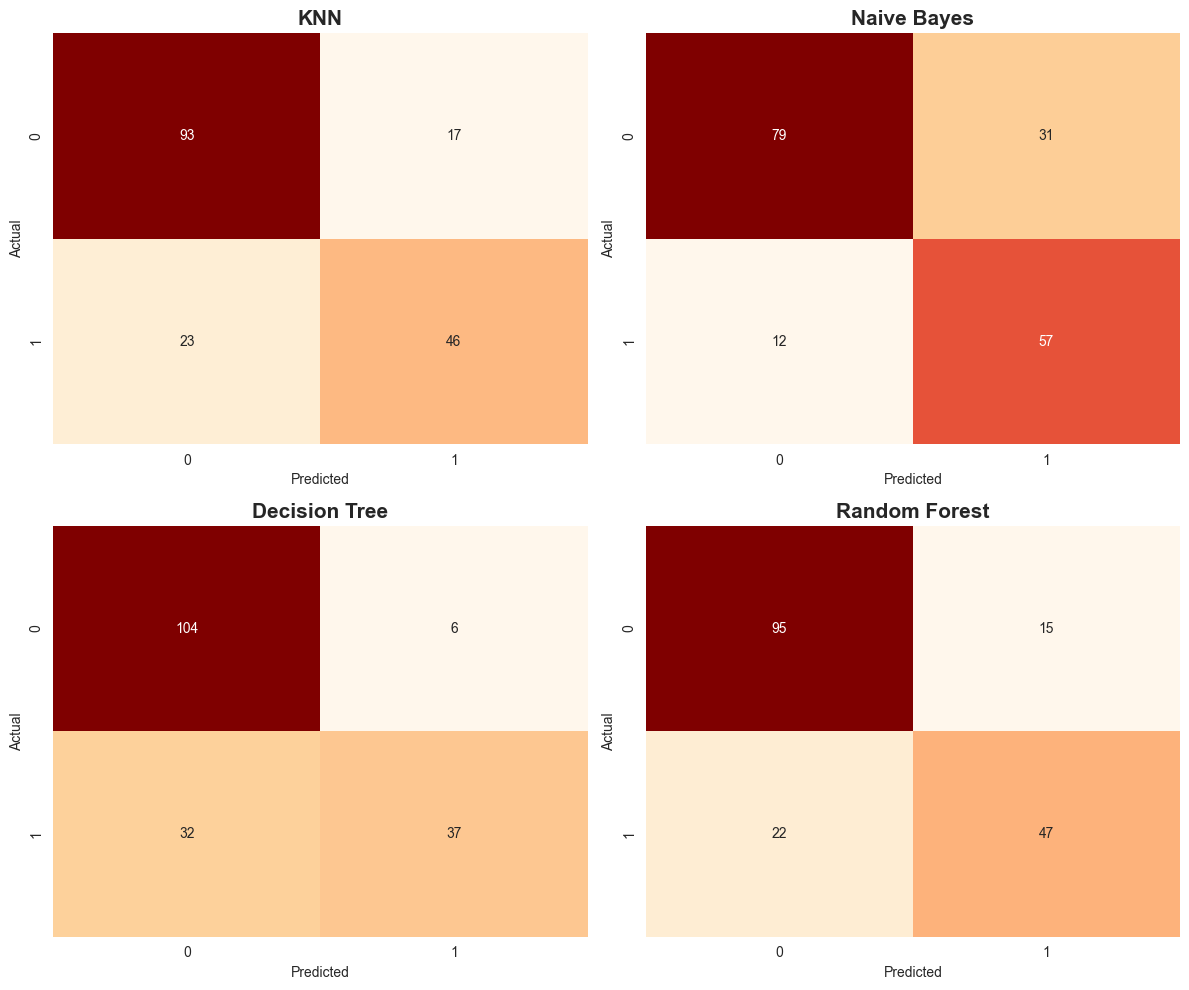

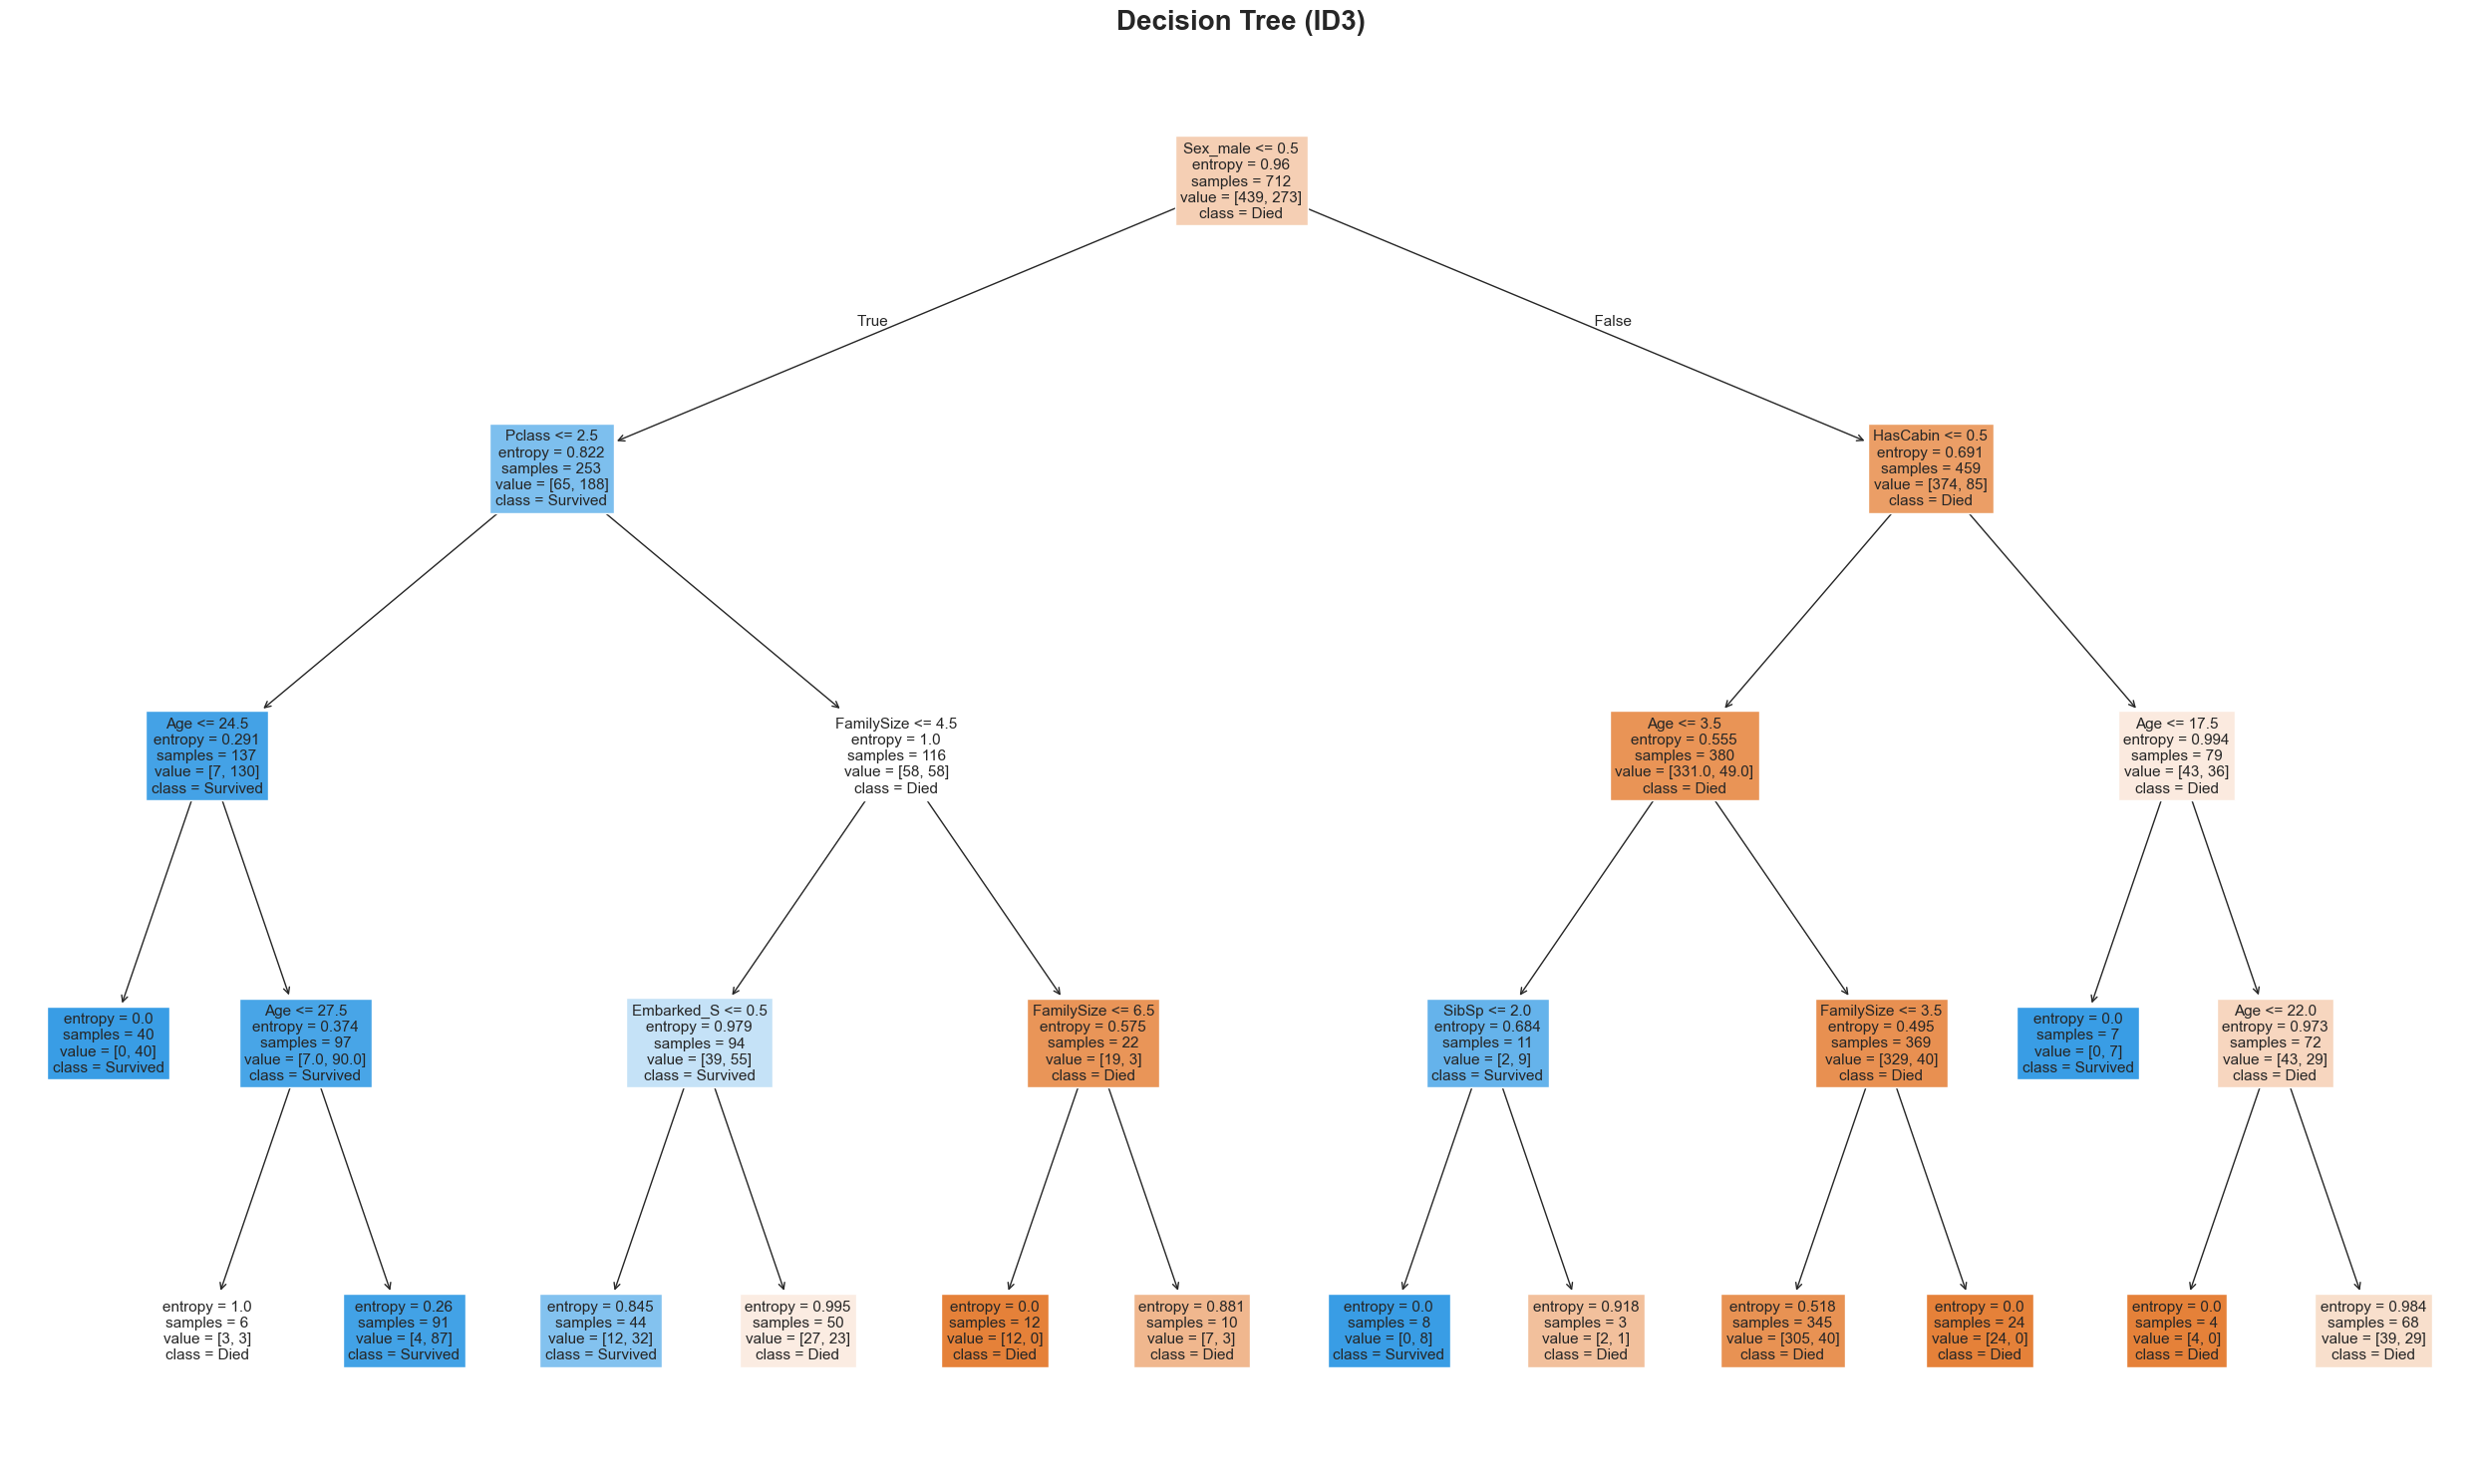

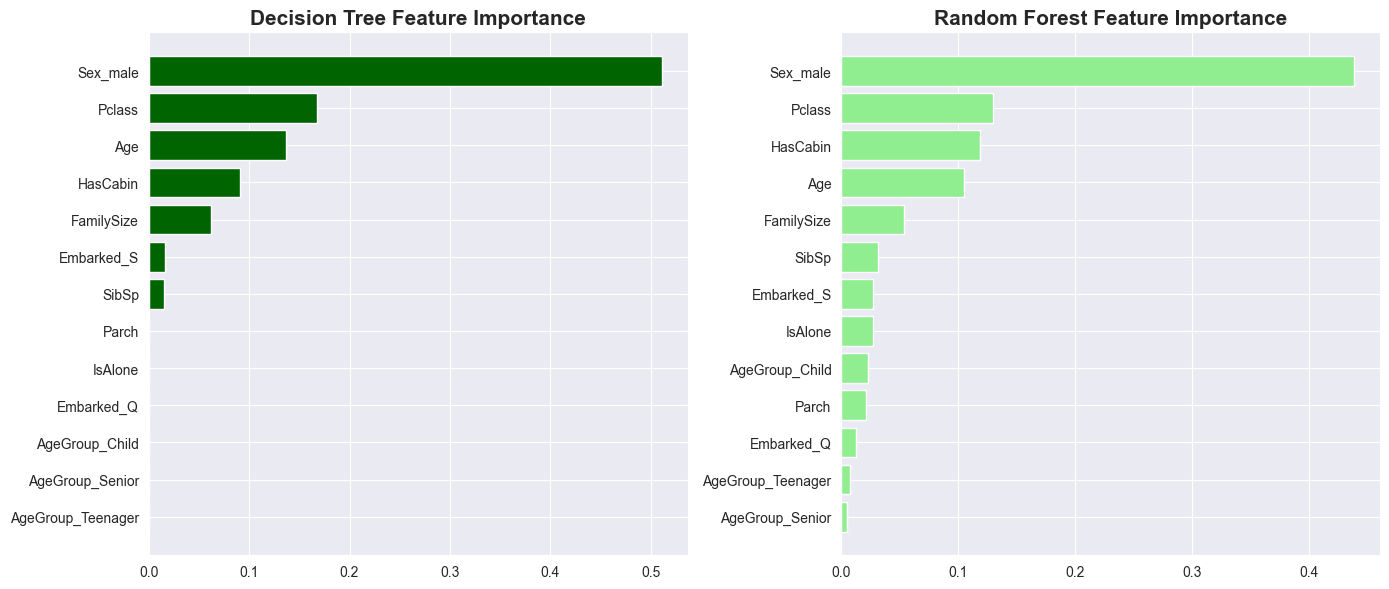

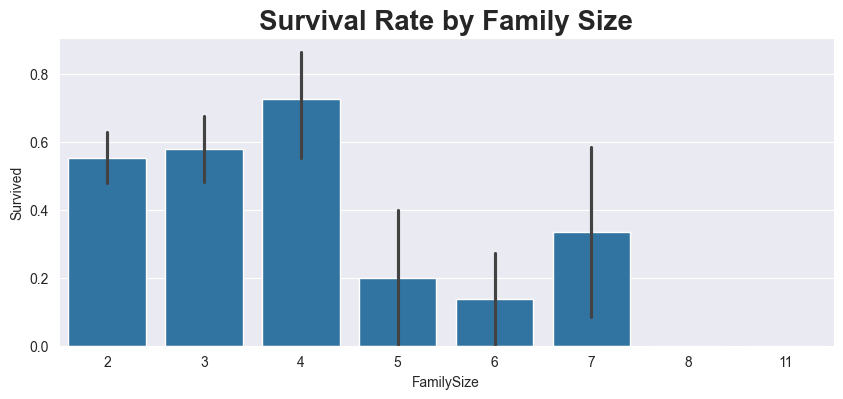

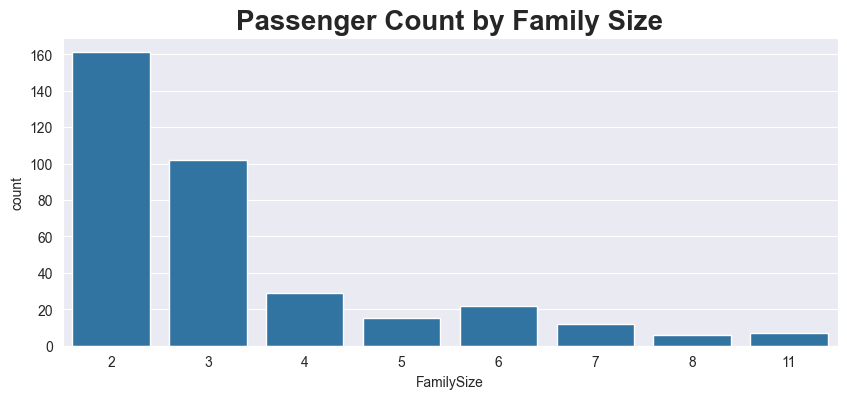

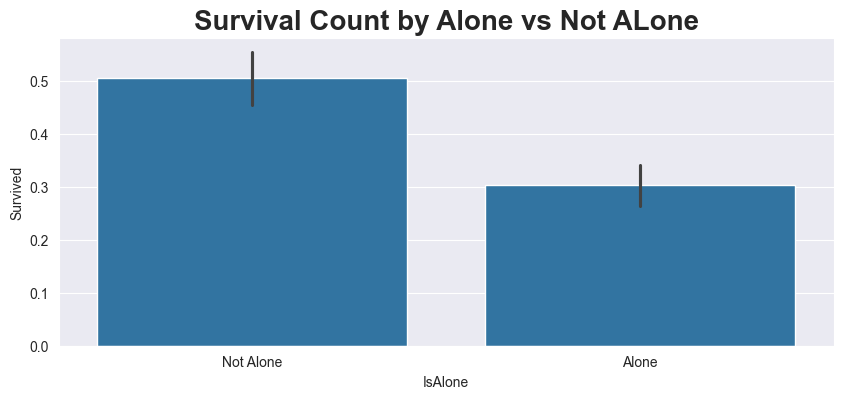

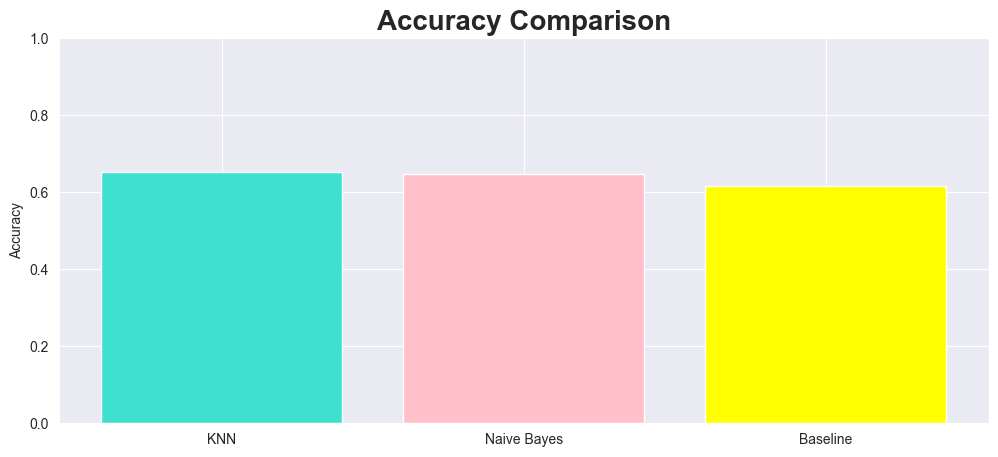

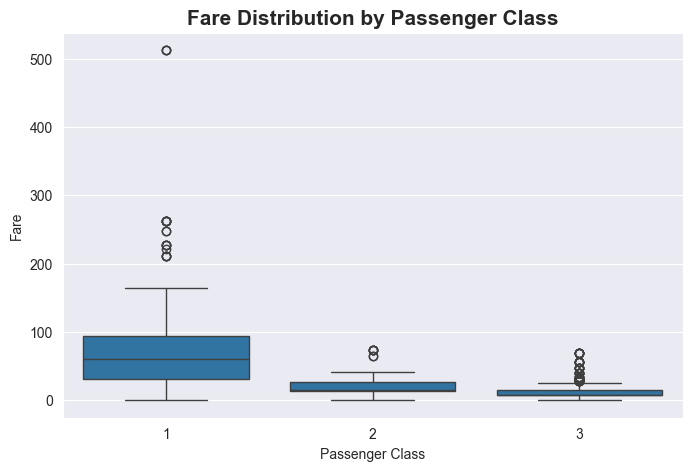

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, auc, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import math

# Unclean Data
trainDf = pd.read_csv('train.csv')
testDf = pd.read_csv('test.csv')
combinedDf = pd.concat([trainDf, testDf])

# Cleaned Data
cleanTrainDf = pd.read_csv('train_cleaned.csv')
cleanTrainDf.set_index('PassengerId')
print(cleanTrainDf.head())

# Data with couples and families only
familyDf = cleanTrainDf[cleanTrainDf['FamilySize'] != 1]

# Problem 1: Which attributes are most important in determining if a person survived or not?
# First we train all our models (KNN, NB, DT, RF)
# Classification using KNN
print(cleanTrainDf.columns)
relevantColumns = relevantColumns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
                   'Embarked', 'HasCabin', 'FamilySize', 'IsAlone', 'AgeGroup']

print(relevantColumns)

# Splitting into x and y
X_knn = cleanTrainDf[relevantColumns]
y_knn = cleanTrainDf['Survived']

# Cool little function to turn categorical data into binary (0 for absence, 1 if it exists), and multicolearinity
X_knn = pd.get_dummies(X_knn, drop_first=True)

print(f"Target distribution:\n\n {y_knn.value_counts(normalize=True)}")
print(f"Baseline: {1 - y_knn.mean():.2f}") # what we're trying to get higher than

# Normalizing and Splitting (80% for training, 20% for testing)
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.2, stratify=y_knn, random_state=42)

# Scaling and Fitting
scaler = StandardScaler()
X_train_knn = scaler.fit_transform(X_train_knn)
X_test_knn = scaler.transform(X_test_knn)

# Training our KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_knn, y_train_knn)
print("KNN trained.")

# Using our model to predict test data (predictions: 0,1) (probabilities: (0.4, 0.6, 0.8)
y_pred_knn = knn.predict(X_test_knn)
y_prob_knn = knn.predict_proba(X_test_knn)[:, 1]

# Evaluating KNN model
print("\nMetrics:")
knn_accuracy = accuracy_score(y_test_knn, y_pred_knn)
knn_precision = precision_score(y_test_knn, y_pred_knn, zero_division=0)
knn_recall = recall_score(y_test_knn, y_pred_knn, zero_division=0)
knn_auc = roc_auc_score(y_test_knn, y_prob_knn)

# Confusion Matrix
print("\nConfusion Matrix:")
cm_knn = confusion_matrix(y_test_knn, y_pred_knn)
print(f"[TN  FP]\n[FN  TP]\n") # displayed in this format
print(cm_knn)

# Detailed Report
print("\nClassification Report:")
print(classification_report(y_test_knn, y_pred_knn, target_names=['Died', 'Survived'], zero_division=0))

# Classification using Naive Bayes
nb_model = GaussianNB()

nb_model.fit(X_train_knn, y_train_knn)
print("NB trained.")

y_pred_nb = nb_model.predict(X_test_knn)
y_prob_nb = nb_model.predict_proba(X_test_knn)[:, 1]

print("\nMetrics:")
nb_accuracy = accuracy_score(y_test_knn, y_pred_nb)
nb_precision = precision_score(y_test_knn, y_pred_nb, zero_division=0)
nb_recall = recall_score(y_test_knn, y_pred_nb, zero_division=0)
nb_auc = roc_auc_score(y_test_knn, y_prob_nb)

print("\nConfusion Matrix:")
cm_nb = confusion_matrix(y_test_knn, y_pred_nb)
print(f"[TN  FP]\n[FN  TP]\n")
print(cm_nb)



print("\nClassification Report:")
print(classification_report(y_test_knn, y_pred_nb, target_names=['Died', 'Survived'], zero_division=0))

# Decision Trees using ID3 (Entropy and Information Gain) Manually calculating entropy and Information Gain and then using DecisionTreeClassifier for plotting.
def calculate_entropy(data, target_column): # Entropy of 0 = pure leaf node, entropy of 1 = minimum purity
    total_rows = len(data)
    target_values = data[target_column].unique()

    entropy = 0
    for value in target_values:
        value_count = len(data[data[target_column] == value])
        proportion = value_count / total_rows
        entropy -= proportion * math.log2(proportion) if proportion != 0 else 0

    return entropy

entropy_outcome = calculate_entropy(cleanTrainDf, 'Survived')
print(f"\nEntropy of the target variable \"Survived\": {entropy_outcome:.3f}\n") # explain in doc

def calculate_information_gain(data, feature, target_column): # higher the information gain, the more useful the feature is
    unique_values = data[feature].unique()
    weighted_entropy = 0

    for value in unique_values:
        subset = data[data[feature] == value]
        proportion = len(subset) / len(data)
        weighted_entropy += proportion * calculate_entropy(subset, target_column)

    information_gain = entropy_outcome - weighted_entropy

    return information_gain

feature_importance = []
for column in cleanTrainDf.columns:
    if column == 'Survived':
        continue
    entropy = calculate_entropy(cleanTrainDf, column)
    information_gain = calculate_information_gain(cleanTrainDf, column, 'Survived')
    feature_importance.append({
        'Feature': column,
        'Entropy': entropy,
        'Information Gain': information_gain})
    feature_importance_df = pd.DataFrame(feature_importance).sort_values('Information Gain', ascending=False)
    print(f"Feature: {column} Entropy: {entropy:.3f}, Information Gain: {information_gain:.3f}")

# Creating the decision tree
X_dt = cleanTrainDf[relevantColumns]
y_dt = cleanTrainDf['Survived']
# Turning categorical into binary
X_dt = pd.get_dummies(X_dt, drop_first=True)

X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, test_size=0.2, stratify=y_dt, random_state=42)

dt = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)
dt.fit(X_train_dt, y_train_dt)

y_pred_dt = dt.predict(X_test_dt)
y_prob_dt = dt.predict_proba(X_test_dt)[:, 1]

dt_accuracy = accuracy_score(y_test_dt, y_pred_dt)
dt_precision = precision_score(y_test_dt, y_pred_dt, zero_division=0)
dt_recall = recall_score(y_test_dt, y_pred_dt, zero_division=0)
dt_auc = roc_auc_score(y_test_dt, y_prob_dt)

dt_cm = confusion_matrix(y_test_dt, y_pred_dt)
print(f"[TN  FP]\n[FN  TP]\n")
print(dt_cm)


print(classification_report(y_test_dt, y_pred_dt, target_names=['Died', 'Survived'], zero_division=0))


# Training Random Forest Model
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
rf.fit(X_train_dt, y_train_dt)
print("Random Forest trained.")

rf_pred = rf.predict(X_test_dt)
rf_prob = rf.predict_proba(X_test_dt)[:, 1]

rf_accuracy = accuracy_score(y_test_dt, rf_pred)
rf_precision = precision_score(y_test_dt, rf_pred, zero_division=0)
rf_recall = recall_score(y_test_dt, rf_pred, zero_division=0)
rf_auc = roc_auc_score(y_test_dt, rf_prob)

rf_cm = confusion_matrix(y_test_dt, rf_pred)
print(f"[TN  FP]\n[FN  TP]\n")
print(rf_cm)


print(classification_report(y_test_dt, rf_pred, target_names=['Died', 'Survived'], zero_division=0))

dt_importance = pd.DataFrame({
    'Feature': X_dt.columns,
    'DT_Importance': dt.feature_importances_
}).sort_values('DT_Importance', ascending=False)

rf_importance = pd.DataFrame({
    'Feature': X_dt.columns,
    'RF_Importance': rf.feature_importances_
}).sort_values('RF_Importance', ascending=False)

# Second problem
family_features = ['SibSp', 'Parch', 'FamilySize', 'IsAlone']
X_family = cleanTrainDf[family_features]
y_family = cleanTrainDf["Survived"]
X_train_family, X_test_family, y_train_family, y_test_family = train_test_split(X_family, y_family, test_size=0.2, stratify=y_dt, random_state=42)

#Using KNN
scaler_fam = StandardScaler()
X_train_family = scaler_fam.fit_transform(X_train_family)
X_test_family = scaler_fam.transform(X_test_family)

knn_family = KNeighborsClassifier(n_neighbors=5)
knn_family.fit(X_train_family, y_train_family)

knn_family_pred = knn_family.predict(X_test_family)
knn_family_accuracy = accuracy_score(y_test_family, knn_family_pred)

# Using Naive bayes
nb_fam = GaussianNB()
nb_fam.fit(X_train_family, y_train_family)
nb_fam_pred = nb_fam.predict(X_test_family)
nb_family_accuracy = accuracy_score(y_test_family, nb_fam_pred)

print(f"KNN Accuracy: {knn_family_accuracy:.3f}")
print(f"Naive Bayes Accuracy: {nb_family_accuracy:.3f}")

# Compare to baseline
print(f"\nBaseline: {1 - y_family.mean():.3f}\n")

# Charts for Izu

# Data with couples and families only
familyDf = cleanTrainDf[cleanTrainDf['FamilySize'] != 1]

# Main Model Comparison
comparison_df = pd.DataFrame({ 'Model': ['KNN', 'Naive Bayes', 'Decision Tree', 'Random Forest'], 'Accuracy': [knn_accuracy, nb_accuracy, dt_accuracy, rf_accuracy], 'Precision': [knn_precision, nb_precision, dt_precision, rf_precision], 'Recall': [knn_recall, nb_recall, dt_recall, rf_recall], 'AUC': [knn_auc, nb_auc, dt_auc, rf_auc] })
print(comparison_df)

# Main Model Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
confusion_matrices = [cm_knn, cm_nb, dt_cm, rf_cm]
model_names = ['KNN', 'Naive Bayes', 'Decision Tree', 'Random Forest']

for idx, (cm, name) in enumerate(zip(confusion_matrices, model_names)):
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='OrRd',
        cbar=False,
        ax=axes[idx]
    )
    axes[idx].set_title(name, fontsize=15, fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()


# First Question

# Decision Tree
plt.figure(figsize=(25, 15))
plot_tree(dt, feature_names = X_dt.columns, class_names=['Died', 'Survived'], filled=True, fontsize=11, proportion=False)
plt.title('Decision Tree (ID3)', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

# Comparison between Decision Tree and Random Forest
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].set_title("Decision Tree Feature Importance", fontsize=15, fontweight='bold')
top_dt = dt_importance.head(15)
axes[0].barh(top_dt['Feature'], top_dt['DT_Importance'], color='darkgreen')
axes[0].invert_yaxis()

axes[1].set_title("Random Forest Feature Importance", fontsize=15, fontweight='bold')
top_rf = rf_importance.head(15)
axes[1].barh(top_rf['Feature'], top_rf['RF_Importance'], color='lightgreen')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


# Second Question Introductory Plots
plt.figure(figsize=(10,4))
sns.barplot(x='FamilySize', y='Survived', data=familyDf)
plt.title("Survival Rate by Family Size", fontsize=20, fontweight='bold')
plt.show()

plt.figure(figsize=(10,4))
sns.countplot(x='FamilySize', data=familyDf)
plt.title("Passenger Count by Family Size", fontsize=20, fontweight='bold')
plt.show()

plt.figure(figsize=(10,4))
sns.barplot(x='IsAlone', y='Survived', data=cleanTrainDf)
plt.title("Survival Count by Alone vs Not ALone", fontsize=20, fontweight='bold')
plt.xticks([0,1], ["Not Alone", "Alone"])
plt.show()

# Comparing KNN and NB accuracies
fig, axes = plt.subplots(figsize=(12, 5))

models = ['KNN', 'Naive Bayes', 'Baseline']
accuracies_family = [
    knn_family_accuracy,
    nb_family_accuracy,
    1 - y_family.mean()
]

plt.title("Accuracy Comparison", fontsize=20, fontweight='bold')
plt.bar(models, accuracies_family, color=['turquoise', 'pink', 'yellow'])
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Extra: correlation between fare and class, so I can drop the attribute
# print(cleanTrainDf[['Fare', 'Pclass']].corr())
plt.figure(figsize=(8, 5))
sns.boxplot(x='Pclass', y='Fare', data=cleanTrainDf)
plt.title('Fare Distribution by Passenger Class', fontsize=15, fontweight='bold')
plt.ylabel('Fare')
plt.xlabel('Passenger Class')
plt.show()

